In [2]:
import pickle
import copy
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

<img src="./images/logo.png">

<font color='purple'><center><h1>Link Prediction in Social Networks using Machine Learning</h1> </center></font>
<center> <h3> Recommending "Streamers to Follow" on Twitch </h3> </center>

<center> <h4> Twitch is a video live streaming service operated by Twitch Interactive, a subsidiary of Amazon

### Research Question : Link Prediction in Social Networks - 
Given a social network graph, link prediction is the problem of predicting which new links could be formed some time in the future. This is useful in various tasks such as recommending new friends on Facebook or new topics on Twitter. 

#### Base Paper - 
**The Link-Prediction Problem for Social Networks**   
Liben‐Nowell, D. and Kleinberg, J. (2007), The link‐prediction problem for social networks. J. Am. Soc. Inf. Sci., 58: 1019-1031. doi:10.1002/asi.20591

### Dataset -  Twitch Users


<img src="./images/graph.png">

[http://snap.stanford.edu/data/twitch-social-networks.html]

In [3]:
data = open('./data/musae_ENGB_edges.csv')
next(data)
g = nx.read_edgelist(data, create_using=nx.DiGraph(), delimiter=',', nodetype=int)
print 'GRAPH DETAILS'
print nx.info(g)

GRAPH DETAILS
Name: 
Type: DiGraph
Number of nodes: 7126
Number of edges: 35324
Average in degree:   4.9571
Average out degree:   4.9571


## Steps :
<br>
<font family='fantasy' color='navy' size=3>
1. Randomly sampled 35324 missing edges to create a balanced dataset. <br>
2. Feature Extraction
    <ul>
    <li>Page Rank </li>
    <li>Shortest Path </li>
    <li>Follows Back  </li>
    <li>Followers / Followees  </li>
    <li>Inter Followers / Followees  </li>
    </ul>
3. Standardization  <br>
4. Train / Test Split (70% : 30 %) <br>
5. Model Training <br>
6. Model Evaluation <br>
</font>    

In [4]:
df = pd.read_csv('./data/twitch_preprocessed_data.csv')
df = df.drop(columns=['Unnamed: 0'])
print 'Data Snapshot: '
df.head(5)

Data Snapshot: 


,Source,Destination,Class,Page_Rank_Src,Page_Rank_Dst,Shortest_Path,Follows_Back,Followers_Src,Followees_Src,Followers_Dst,Followees_Dst,Int_Followers,Int_Followees
0,6194,255,1,0.013325,0.002871,0.000000,0.0,0.0,0.01,0.0000,0.0075,0.0,0.000000
1,6194,980,1,0.013325,0.003198,0.000000,0.0,0.0,0.01,0.0000,0.0375,0.0,0.013158
2,6194,2992,1,0.013325,0.004148,0.217391,0.0,0.0,0.01,0.0075,0.0000,0.0,0.000000
3,6194,2507,1,0.013325,0.018890,0.173913,0.0,0.0,0.01,0.0200,0.0325,0.0,0.000000
4,6194,986,1,0.013325,0.005404,0.391304,0.0,0.0,0.01,0.0025,0.0450,0.0,0.000000


## Data Visualization

Feature Correlation Heatmap


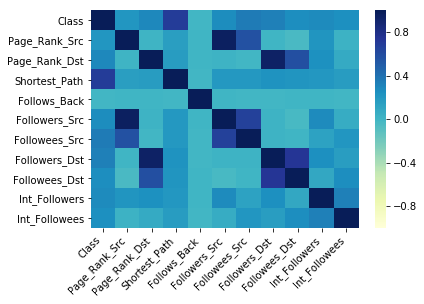

In [5]:
print 'Feature Correlation Heatmap'
data = df.drop(columns=['Source', 'Destination'])
corr = data.corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='YlGnBu')

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The above heatmap shows that the **Shortest_Path** feature is most strongly correlated with class and the **Follows_Back** feature is least correlated. Almost all the features are positively correlated with Class which means we can expect good results from our models.


(-1, 2)

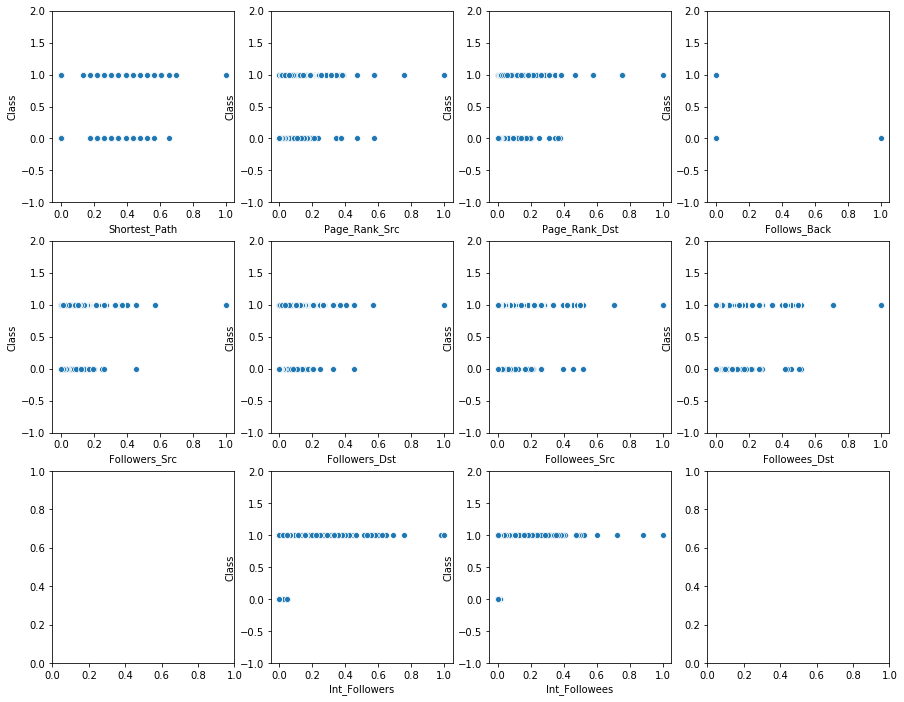

In [6]:
dims = (15, 12)
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=dims)

sns.scatterplot(x='Shortest_Path', y='Class', data=df, ax=axs[0][0])
sns.scatterplot(x='Page_Rank_Src', y='Class', data=df, ax=axs[0][1])
sns.scatterplot(x='Page_Rank_Dst', y='Class', data=df, ax=axs[0][2])
sns.scatterplot(x='Follows_Back', y='Class', data=df, ax=axs[0][3])

sns.scatterplot(x='Followers_Src', y='Class', data=df, ax=axs[1][0])
sns.scatterplot(x='Followers_Dst', y='Class', data=df, ax=axs[1][1])
sns.scatterplot(x='Followees_Src', y='Class', data=df, ax=axs[1][2])
sns.scatterplot(x='Followees_Dst', y='Class', data=df, ax=axs[1][3])

sns.scatterplot(x='Int_Followers', y='Class', data=df, ax=axs[2][1])
sns.scatterplot(x='Int_Followees', y='Class', data=df, ax=axs[2][2])

axs[0,0].set_ylim(-1, 2)
axs[0,1].set_ylim(-1, 2)
axs[0,2].set_ylim(-1, 2)
axs[0,3].set_ylim(-1, 2)
axs[1,0].set_ylim(-1, 2)
axs[1,1].set_ylim(-1, 2)
axs[1,2].set_ylim(-1, 2)
axs[1,3].set_ylim(-1, 2)
axs[2,1].set_ylim(-1, 2)
axs[2,2].set_ylim(-1, 2)

## Model Evalution

In [7]:
df_x = df.drop(columns=['Source', 'Destination', 'Class'])
df_y = df[['Class']]
x_train, x_test, y_train, y_test  = train_test_split(df_x, df_y, test_size = 0.3, random_state=7)

In [8]:
f1 = open('./data/twitch_lr_model.p')
lr_model = pickle.load(f1)

f2 = open('./data/twitch_rf_model.p')
rf_model = pickle.load(f2)

f3 = open('./data/twitch_svm_model.p')
svm_model = pickle.load(f3)

f4 = open('./data/twitch_xgb_model.p')
xgb_model = pickle.load(f4)

In [9]:
def plot_roc(y_test, y_pred):
    fpr,tpr,ths = roc_curve(y_test, y_pred)
    auc_ = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='tab:blue',label='ROC curve (area = %0.2f)' % auc_)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Plot')
    plt.legend()
    plt.show()

In [10]:
def plot_confusion(y_test, y_pred):
    
    C = confusion_matrix(y_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(3,3))
    
    labels = [0,1]
    cmap=sns.light_palette("tab:blue")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

### 1. Logistic Regression

In [11]:
lr_y_pred = lr_model.predict(x_test)

In [12]:
print 'Classification Report: '
print classification_report(lr_y_pred, y_test) 

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     11202
           1       0.92      0.98      0.95      9993

   micro avg       0.95      0.95      0.95     21195
   macro avg       0.95      0.95      0.95     21195
weighted avg       0.95      0.95      0.95     21195



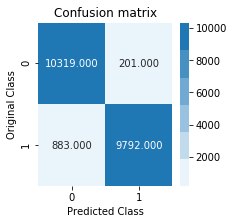

In [13]:
plot_confusion(y_test, lr_y_pred) 

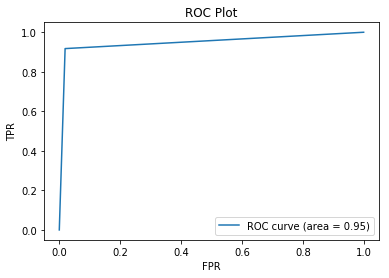

In [14]:
plot_roc(y_test, lr_y_pred)

### 2. Random Forest

In [15]:
rf_y_pred = rf_model.predict(x_test)

In [16]:
print 'Classification Report: '
print classification_report(rf_y_pred, y_test) 

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10795
           1       0.96      0.98      0.97     10400

   micro avg       0.97      0.97      0.97     21195
   macro avg       0.97      0.97      0.97     21195
weighted avg       0.97      0.97      0.97     21195



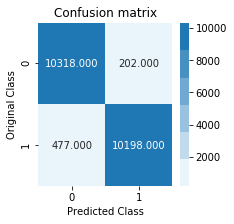

In [17]:
plot_confusion(y_test, rf_y_pred) 

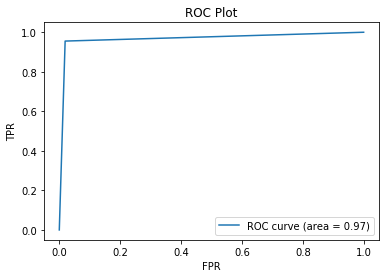

In [18]:
plot_roc(y_test, rf_y_pred)

### 3. SVM

In [19]:
svm_y_pred = svm_model.predict(x_test)

In [20]:
print 'Classification Report: '
print classification_report(svm_y_pred, y_test) 

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     11527
           1       0.89      0.99      0.94      9668

   micro avg       0.94      0.94      0.94     21195
   macro avg       0.94      0.94      0.94     21195
weighted avg       0.94      0.94      0.94     21195



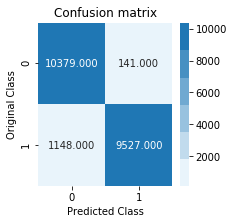

In [21]:
plot_confusion(y_test, svm_y_pred) 

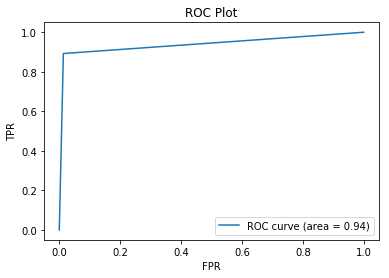

In [22]:
plot_roc(y_test, svm_y_pred)

### 4. XGBoost

In [23]:
xgb_y_pred = xgb_model.predict(x_test)

In [24]:
print 'Classification Report: '
print classification_report(xgb_y_pred, y_test) 

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10795
           1       0.96      0.98      0.97     10400

   micro avg       0.97      0.97      0.97     21195
   macro avg       0.97      0.97      0.97     21195
weighted avg       0.97      0.97      0.97     21195



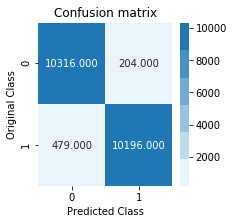

In [25]:
plot_confusion(y_test, xgb_y_pred) 

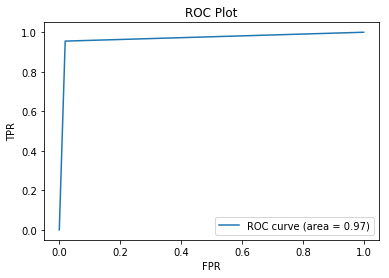

In [26]:
plot_roc(y_test, xgb_y_pred)

### Feature Importance

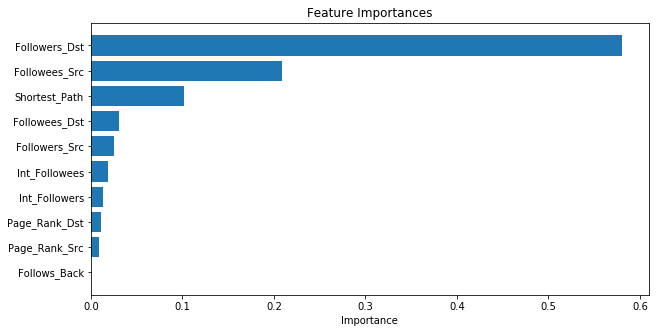

In [27]:
features = df.columns.drop(['Class', 'Source', 'Destination'])
imp = xgb_model.feature_importances_
idx = (np.argsort(imp))[-25:]
plt.figure(figsize=(10,5))
plt.title('Feature Importances')
plt.barh(range(len(idx)), imp[idx], color='tab:blue', align='center')
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.xlabel('Importance')
plt.show()